**CBIS-DDSM (Curated Breast Imaging Subset of DDSM)** [^1] is a [Mammography](mammography.md) dataset for [Computer-Aided Detection (CADe)](../../../permanent/computer-aided-detection-cade.md) and [Computer-Aided Diagnosis (CADx)](../../../permanent/computer-aided-diagnosis.md), derived from an earlier dataset, the Digital Database for Screening Mammography (DDSM) [^2]. This note comes from background research for my Breast Cancer Detection BSc final project.

The idea of CBIS-DDSM was to provide a standardised mammography dataset towards an [ImageNet](../../../permanent/ImageNet.md) for mammography. Though a few mammography datasets already existed: the DDSM itself [^2], the Mammographic Imaging Analysis Society (MIAS) database [^3], and the Image Retrieval in Medical Applications (IRMA) project [^4], they were limited by accessibility and data quality issues.

DDSM was already a promising dataset for this purpose, comprising 2620 scanned mammography studies from multiple hospitals. It contains ROI annotations and [Breast Imaging Reporting and Data System (BI-RADS)](breast-imaging-reporting-and-data-system-bi-rads.md) labels for a series of Mammography studies, along with extensive metadata. However, it had several problems: inaccurate region-of-interest annotations, personal health information in some images, and an obsolete file format (LJPEG).

The authors of the CBIS-DDSM subset stripped the dubious annotations and the examples containing PII. They also wrote a conversion tool for LJPEG and converted the images into TIFF files, which are then stored as [DICOM](dicom.md) files, the standard for medical images, to create CBIS-DDSM.

They also included convenience images, including the region-of-interest mask and the cropped region. You can see an example of it later in the article.

Finally, they improved the accuracy of the existing region-of-interest annotations by applying the [Chan-Vese Algorithm](chan-vese-algorithm.md), initialised with the original contours, but only to the mass examples, not the calcifications. In the figure below, in red, the original annotations; in blue, some example annotations created by physicians; and in green, the annotations derived from the Chan-Vese model, which clearly improve on the original annotations.

![Figure 2 from Lee et al demonstrating the Chan-Vese algorithm for improving ROI annotations](../_media/cbis-ddsm-figure-2.png)

I'm going to walk through how the dataset works in this rendered notebook.

The dataset can be downloaded from the [Cancer Imaging Archive](https://www.cancerimagingarchive.net/collection/cbis-ddsm).

I downloaded the **Images** dataset to the `~/datasets/CBIS-DDSM` folder, which uncompresses into the `./CBIS-DDSM` directory.

The image dataset is a 164GB compressed dataset, which uncompresses to around 180GB.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import pandas as pd
import pydicom

pd.set_option('display.max_colwidth', None)

In [2]:
DATASET_ROOT = Path("/Users/lex/datasets/CBIS-DDSM")

!cd {DATASET_ROOT} && du -sh *.csv CBIS-DDSM

512K	calc_case_description_test_set.csv
1.0M	calc_case_description_train_set.csv
512K	mass_case_description_test_set.csv
1.0M	mass_case_description_train_set.csv
3.0M	metadata.csv
180G	CBIS-DDSM


2 files are provided for each split, representing either **calcification** or **mass abnormalities** found in the breast.

- `calc_case_description_{train|test}_set.csv`
- `mass_case_description_{train|test}_set.csv`

In [3]:
train_mass_df = pd.read_csv(DATASET_ROOT / "mass_case_description_train_set.csv")
train_mass_df.head(1).T

,0
patient_id,P_00001
breast_density,3
left or right breast,LEFT
image view,CC
abnormality id,1
abnormality type,mass
mass shape,IRREGULAR-ARCHITECTURAL_DISTORTION
mass margins,SPICULATED
assessment,4
pathology,MALIGNANT


Before we get to the metadata, let's take a look at some major bugs with the provided CSV.

### Addressing Inconsistent Image Mappings

As you can see, each row in the CSV files contains references to 3 DICOM files:

- `image file path` - the full mammogram
- `ROI mask file path` - binary mask of the region of interest
- `cropped image file path` - cropped region containing the abnormality

However, the DICOM filenames don't match the files downloaded from the **Images** dataset in a quite confusing way.

The CSVs reference files like `000000.dcm` or `000001.dcm`, but the actual files are named `1-1.dcm` or `1-2.dcm`. Even worse, the mapping between these naming conventions is inconsistent. Additionally, some entries in the `ROI mask file path` column incorrectly point to cropped images rather than actual binary masks.

Thankfully, Andrés Sarmiento created a [tool](https://gitlab.com/ACSG-64/cbis-ddsm-description-correction-and-verification-tool) that fixes these issues by interrogating the mask files to determine if they're crops or masks, and correcting the filepath references. The corrected CSV files are available as a [HuggingFace dataset](https://huggingface.co/datasets/ACSG-64/CBIS-DDSM-description-corrected).

I downloaded the correct CSV to `~/datasets/CBIS-DDSM/fixed-csv`, and the rest of the notebook will use it accordingly.

## Train / Test Data

As mentioned, the training and test data are split by the abnormality type present in the scan: calcification or mass. I find it easiest to combine the training into a single file:

In [4]:
train_mass_df = pd.read_csv(DATASET_ROOT / "fixed-csv" / "mass_case_description_train_set.csv")
train_calc_df = pd.read_csv(DATASET_ROOT / "fixed-csv" / "calc_case_description_train_set.csv")
train_df = pd.concat([train_mass_df, train_calc_df])
train_mass_df = train_calc_df = None
train_df.head(1).T

,0
patient_id,P_00001
breast_density,3.0
left or right breast,LEFT
image view,CC
abnormality id,1
abnormality type,mass
mass shape,IRREGULAR-ARCHITECTURAL_DISTORTION
mass margins,SPICULATED
assessment,4
pathology,MALIGNANT


We do the same for the test set:

In [5]:
test_mass_df = pd.read_csv(DATASET_ROOT / "fixed-csv" / "mass_case_description_test_set.csv")
test_calc_df = pd.read_csv(DATASET_ROOT / "fixed-csv" / "calc_case_description_test_set.csv")
test_df = pd.concat([test_mass_df, test_calc_df])
test_mass_df = test_calc_df = None
test_df.head(1).T

,0
patient_id,P_00016
breast_density,4.0
left or right breast,LEFT
image view,CC
abnormality id,1
abnormality type,mass
mass shape,IRREGULAR
mass margins,SPICULATED
assessment,5
pathology,MALIGNANT


Then combine both splits for analysis:

In [6]:
all_df = pd.concat([train_df, test_df])

The `metadata.csv` file maps the CSV path references to actual file locations on disk:

In [7]:
metadata_df = pd.read_csv(DATASET_ROOT / "metadata.csv")
metadata_df.head(1).T

,0
Series UID,1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515
Collection,CBIS-DDSM
3rd Party Analysis,NaN
Data Description URI,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY
Subject ID,Calc-Test_P_00038_LEFT_CC_1
Study UID,1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942
Study Description,NaN
Study Date,08-29-2017
Series Description,ROI mask images
Manufacturer,NaN


CBIS-DDSM contains 1,566 studies.

In [8]:
images_per_patient = all_df.groupby("patient_id").size()
print(f"Total patients: {len(images_per_patient)}")

Total patients: 1566


They separate the studies by the abnormality type present, either "mass" or "calcification".

The paper[^1] claims there are 891 mass cases, although the actual dataset appears to have 892 mass abnormalities.

In [9]:
len(all_df[all_df["abnormality type"] == "mass"].patient_id.unique())

892

The paper also describes 753 calcification abnormalities that match what we see.

In [10]:
len(all_df[all_df["abnormality type"] == "calcification"].patient_id.unique())

753

We know that a mammogram consists of 2 images per breast: a craniocaudal (CC) view from above and a mediolateral oblique (MLO) view from the side.

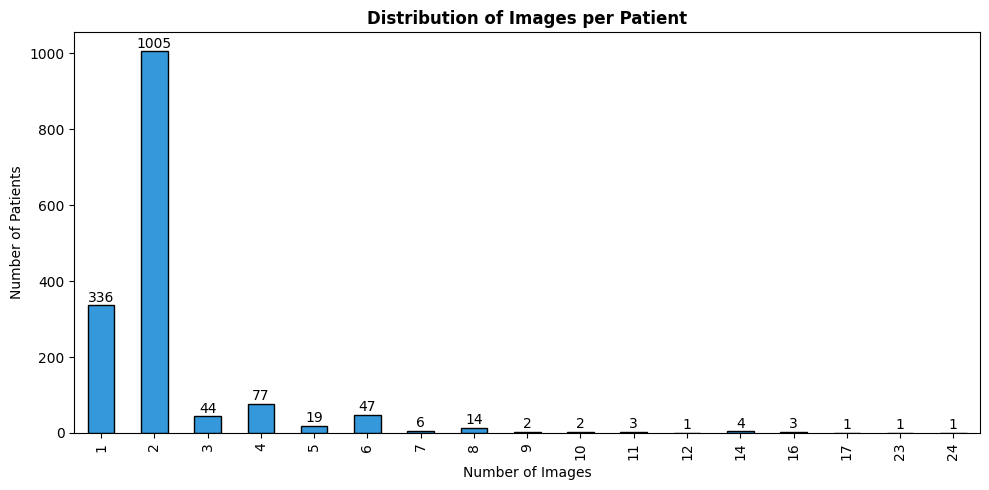

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
images_per_patient.value_counts().sort_index().plot(kind='bar', ax=ax, color='#3498db', edgecolor='black')
ax.set_title('Distribution of Images per Patient', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of Patients')
for i, v in enumerate(images_per_patient.value_counts().sort_index().values):
    ax.text(i, v + 2, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

Looking at the distribution of images per patient, about 1005 patients have both views, while many have only a single image, which is basically an incomplete mammogram (containing only one view per patient, instead of the expected two).

## Fetching Images

Even with the corrected CSVs, we still need to do a few things to look up the DICOM images for each study.

The file paths in the CSV (e.g. `Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm`) aren't direct paths to the files on disk. They encode metadata: subject ID, study UID, series UID, and filename. We need to parse these components and cross-reference with `metadata.csv` to find the actual file location.

In [12]:
from pydantic import BaseModel

class DCMData(BaseModel):
    subject_id: str
    study_uid: str
    series_uid: str
    dcm_file: str

def get_file_data_from_dcm(dcm_path: str) -> DCMData:
    """Parse DICOM path string to extract metadata components."""
    data = str(dcm_path).strip().split("/")
    dcm_og = data[-1].strip().split(".")[0]
    return DCMData(
        subject_id=data[0],
        study_uid=data[1],
        series_uid=data[2],
        dcm_file=dcm_og,
    )

In [13]:
def get_filepath_from_dcm_data(dcm_data: DCMData) -> Path:
    """Look up actual file path from metadata using DCM data."""
    meta_row = metadata_df[
        (metadata_df["Subject ID"] == dcm_data.subject_id)
        & (metadata_df["Series UID"] == dcm_data.series_uid)
        & (metadata_df["Study UID"] == dcm_data.study_uid)
    ].iloc[0]
    file_location = meta_row["File Location"]
    return DATASET_ROOT / Path(file_location) / (dcm_data.dcm_file + ".dcm")

Now we can load the DICOM images using pydicom:

In [14]:
def dicom_to_array(file_path: Path):
    """Load a DICOM file and return pixel array."""
    ds = pydicom.dcmread(file_path)
    return ds.pixel_array

Let's load an example patient to see all three image types (full mammogram, ROI mask, and cropped region):

In [15]:
patient_df = all_df[all_df.patient_id == "P_00065"]
row = patient_df[patient_df["image view"] == "CC"].iloc[0]

img_path = get_filepath_from_dcm_data(get_file_data_from_dcm(row["image file path"]))
mask_path = get_filepath_from_dcm_data(get_file_data_from_dcm(row["ROI mask file path"]))
crop_path = get_filepath_from_dcm_data(get_file_data_from_dcm(row["cropped image file path"]))

original_img = dicom_to_array(img_path)
mask_img = dicom_to_array(mask_path)
crop_img = dicom_to_array(crop_path)

Visualising the original mammogram, the binary ROI mask, an overlay of the two, and the cropped abnormality region:

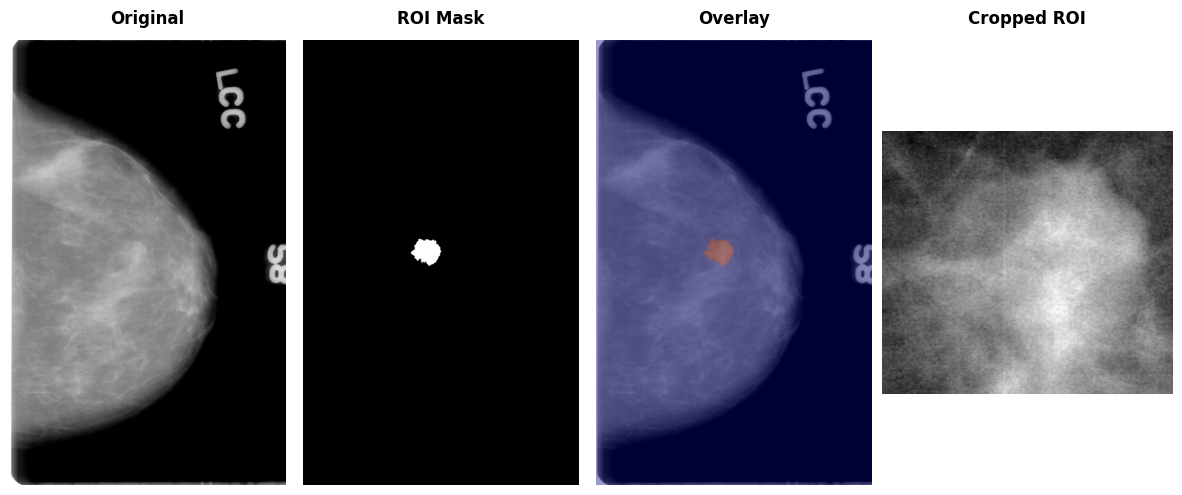

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))

axes[0].imshow(original_img, cmap="gray")
axes[0].axis("off")

axes[1].imshow(mask_img, cmap="gray")
axes[1].axis("off")

axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(mask_img, cmap="jet", alpha=0.4)
axes[2].axis("off")

axes[3].imshow(crop_img, cmap="gray")
axes[3].axis("off")

plt.tight_layout()
fig.subplots_adjust(top=0.92, wspace=0.01)

titles = ["Original", "ROI Mask", "Overlay", "Cropped ROI"]
for ax, title in zip(axes, titles):
    x = ax.get_position().x0 + ax.get_position().width / 2
    fig.text(x, 0.98, title, ha="center", va="top", fontsize=12, fontweight="bold")
plt.show()

## Key Metadata

The most important label is `pathology`, indicating whether the abnormality is **benign**, **benign_without_callback** (clearly no risk of malignancy), or **malignant**.

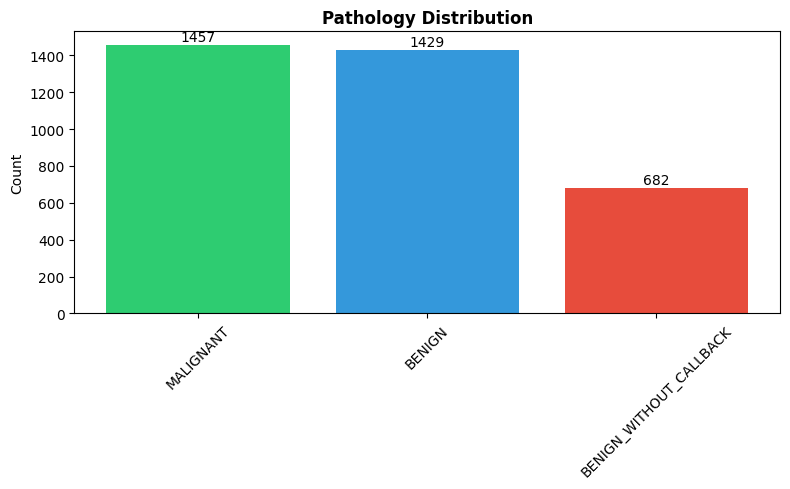

In [17]:
pathology_counts = all_df['pathology'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(pathology_counts.index, pathology_counts.values, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Pathology Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(pathology_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

The dataset also includes [Breast Imaging Reporting and Data System (BI-RADS)](breast-imaging-reporting-and-data-system-bi-rads.md) assessment categories (0-6) that indicate the level of suspicion. The distribution shows most cases fall into categories 4 and 5 (suspicious/highly suggestive of malignancy), which makes sense given that this is a dataset specifically curated around abnormalities.

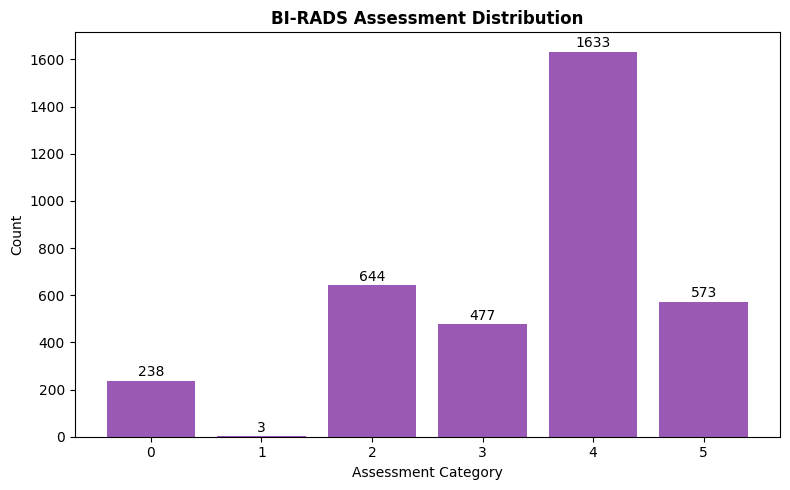

In [18]:
assessment_counts = all_df['assessment'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(assessment_counts.index.astype(str), assessment_counts.values, color='#9b59b6')
plt.title('BI-RADS Assessment Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Assessment Category')
plt.ylabel('Count')
for i, (idx, v) in enumerate(assessment_counts.items()):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Mass Descriptors

For mass abnormalities, the dataset includes shape and margin descriptors - clinically important features for diagnosis:

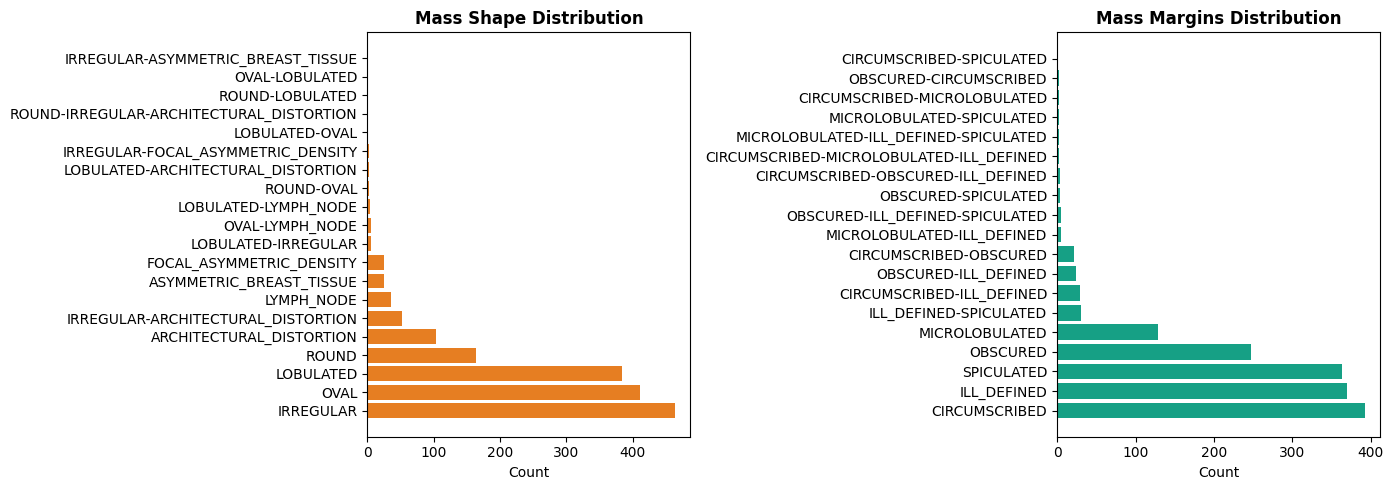

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

shape_counts = all_df['mass shape'].dropna().value_counts()
axes[0].barh(shape_counts.index, shape_counts.values, color='#e67e22')
axes[0].set_title('Mass Shape Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')

margins_counts = all_df['mass margins'].dropna().value_counts()
axes[1].barh(margins_counts.index, margins_counts.values, color='#16a085')
axes[1].set_title('Mass Margins Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

Irregular shapes and spiculated margins are typically more concerning for malignancy, while oval/round shapes with circumscribed margins tend to be benign.

### Breast Density

Breast density (1-4 scale) affects mammogram interpretation - denser tissue makes abnormalities harder to detect:

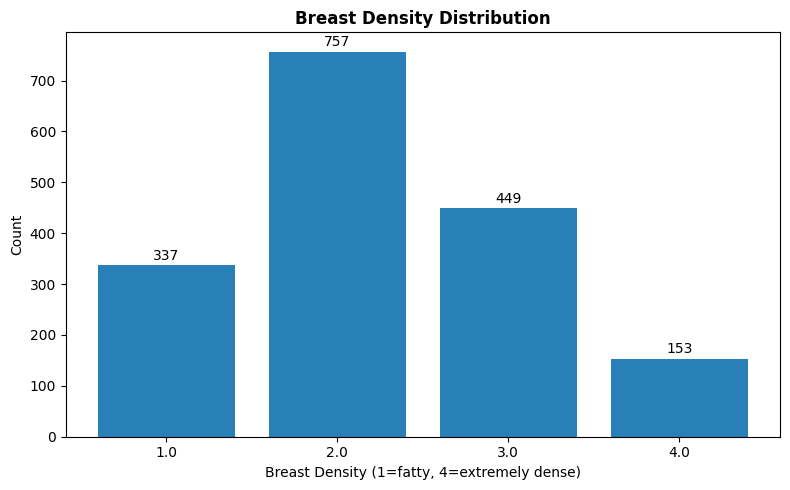

In [20]:
density_col = 'breast_density' if 'breast_density' in all_df.columns else 'breast density'
breast_density_counts = all_df[density_col].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(breast_density_counts.index.astype(str), breast_density_counts.values, color='#2980b9')
plt.title('Breast Density Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Breast Density (1=fatty, 4=extremely dense)')
plt.ylabel('Count')
for i, v in enumerate(breast_density_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Train/Test Split

The authors provide standardised train/test splits (80/20), stratified by BI-RADS assessment to ensure similar difficulty distribution:

| Set | Benign Cases | Malignant Cases |
|-----|--------------|-----------------|
| Calcification Training | 329 (552 abnormalities) | 273 (304 abnormalities) |
| Calcification Test | 85 (112 abnormalities) | 66 (77 abnormalities) |
| Mass Training | 355 (387 abnormalities) | 336 (361 abnormalities) |
| Mass Test | 117 (135 abnormalities) | 83 (87 abnormalities) |

Note that case counts differ from abnormality counts since some cases contain multiple abnormalities.

## Segmentation Quality

The authors validated their Chan-Vese segmentations against hand-drawn ROIs from an experienced radiologist on 118 images. The mean Dice coefficient between computer-generated and hand-drawn ROIs was **0.792 ± 0.108**, compared to **0.398 ± 0.195** for the original DDSM annotations vs hand-drawn. These results represent a statistically significant improvement (Wilcoxon signed-rank test, p = 5.54 × 10⁻¹⁹).

During curation, 339 mass images where the lesion was not clearly visible were removed after review by a trained mammographer.

## Limitations

While CBIS-DDSM is valuable for research, it has some limitations worth noting. The original DDSM images were digitised from film mammograms, not acquired digitally. Modern Full-Field Digital Mammography (FFDM) systems produce higher-quality images, and newer datasets like [InBreast](inbreast.md) and [VinDr-Mammo](vindr-mammo.md) tend to contain these sorts of images. Additionally, DDSM images are focused on a specific abnormality, but a breast may contain multiple abnormalities, warranting investigation. Lastly, the original DDSM was collected in the 1990s, so imaging quality and patient demographics may differ from those in contemporary datasets.

Despite these limitations, CBIS-DDSM remains one of the most widely used public mammography datasets for developing and benchmarking CAD algorithms.

## References

[^1]: Lee, R. S., Gimenez, F., Hoogi, A., Miyake, K. K., Gorovoy, M., & Rubin, D. L. (2017). A curated mammography data set for use in computer-aided detection and diagnosis research. *Scientific Data*, 4(1), 170177. [https://doi.org/10.1038/sdata.2017.177](https://doi.org/10.1038/sdata.2017.177)
[^2]: Heath, M., Bowyer, K., Kopans, D., Moore, R. & Kegelmeyer, W. P. The Digital Database for Screening Mammography. Proceedings of the Fifth International Workshop on Digital Mammography 212–218 (2001). Available at http://marathon.csee.usf.edu/Mammography/software/HeathEtAlIWDM_2000.pdf
[^3]: Suckling, J. et al. The Mammographic Image Analysis Society digital mammogram database. *Exerpta Medica* 375–378 (1994). [http://peipa.essex.ac.uk/info/mias.html](http://peipa.essex.ac.uk/info/mias.html)
[^4]: Lehmann, T. M. et al. IRMA—Content-based image retrieval in medical applications. *Methods Inf. Med.* 43, 354–361 (2004).